In [1]:
import pandas as pd
import tqdm as tqdm

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
main = pd.read_excel('RB(main).xlsx')
hedge = pd.read_excel('hedge.xlsx')

In [4]:
main.head(10)

,date,open,high,low,close,volume
0,2019-01-02 09:01:00,3398.0,3405.0,3389.0,3400.0,79572.0
1,2019-01-02 09:02:00,3401.0,3430.0,3401.0,3409.0,88858.0
2,2019-01-02 09:03:00,3410.0,3414.0,3409.0,3413.0,22584.0
3,2019-01-02 09:04:00,3412.0,3413.0,3403.0,3405.0,17688.0
4,2019-01-02 09:05:00,3404.0,3409.0,3404.0,3406.0,15522.0
5,2019-01-02 09:06:00,3405.0,3406.0,3400.0,3402.0,20498.0
6,2019-01-02 09:07:00,3402.0,3403.0,3400.0,3400.0,13328.0
7,2019-01-02 09:08:00,3401.0,3406.0,3400.0,3406.0,11668.0
8,2019-01-02 09:09:00,3406.0,3413.0,3405.0,3413.0,18370.0
9,2019-01-02 09:10:00,3413.0,3415.0,3411.0,3414.0,18170.0


In [5]:
hedge.head(10)

,date,open,high,low,close,volume
0,2019-01-02 09:01:00,496.5,496.5,492.0,493.5,21786.0
1,2019-01-02 09:02:00,493.5,494.5,492.5,493.0,9238.0
2,2019-01-02 09:03:00,493.0,493.5,492.5,493.5,5824.0
3,2019-01-02 09:04:00,494.0,494.0,493.0,493.0,5762.0
4,2019-01-02 09:05:00,492.5,493.5,492.5,493.5,2572.0
5,2019-01-02 09:06:00,493.0,493.5,492.5,493.5,5618.0
6,2019-01-02 09:07:00,493.5,493.5,493.0,493.0,902.0
7,2019-01-02 09:08:00,493.0,494.0,493.0,494.0,4558.0
8,2019-01-02 09:09:00,494.0,495.0,493.5,495.0,4384.0
9,2019-01-02 09:10:00,495.0,495.0,494.5,495.0,6376.0


In [6]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214080 entries, 0 to 214079
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    214080 non-null  object 
 1   open    214080 non-null  float64
 2   high    214080 non-null  float64
 3   low     214080 non-null  float64
 4   close   214080 non-null  float64
 5   volume  214080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.8+ MB


In [7]:
hedge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214080 entries, 0 to 214079
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    214080 non-null  object 
 1   open    214080 non-null  float64
 2   high    214080 non-null  float64
 3   low     214080 non-null  float64
 4   close   214080 non-null  float64
 5   volume  214080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.8+ MB


In [8]:
def check(df1, df2):
    if df1.iloc[0]['date'] == df2.iloc[0]['date'] and df1.iloc[-1]['date'] == df2.iloc[-1]['date'] and df1.shape[0] == df2.shape[0]:
        return True
    else:
        return False

In [9]:
check(main, hedge)

True

In [65]:
class Base_Strategy:
    
    @staticmethod
    def RSI(df, period = 28):
        
        delta = df['close'].diff()
        
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
          
        ema_up = up.ewm(com = period - 1, min_periods = period).mean()
        ema_down = down.ewm(com = period - 1, min_periods = period).mean()

        RSI = 100 - (100 / (1 + ema_up / ema_down))
        
        return RSI
    
    @staticmethod
    def calc_bias(main, hedge):
        
        small_bias = Base_Strategy.RSI(main) - Base_Strategy.RSI(hedge)
        big_bias = Base_Strategy.RSI(main.iloc[list(range(0, main.shape[0], 60))]) - Base_Strategy.RSI(hedge.iloc[list(range(0, hedge.shape[0], 60))])
            
        return small_bias, big_bias
    
    @staticmethod
    def signal_times(main, hedge, period, min_val = 10, max = 90):
        
        # Base_Strategy.calc_bias(main, hedge)[1] = big bias
        # Base_Strategy.calc_bias(main, hedge)[0] = small bias
        
        Big_Bias = Base_Strategy.calc_bias(main, hedge)[1]
        Small_Bias = Base_Strategy.calc_bias(main, hedge)[0]
        
        time_of_buy = []
        time_of_sell = []
        
        for i in range(period - 1, main.shape[0] - 1680):
            
            if Big_Bias.iloc[(i + period * 59) // 60] > 0 and Big_Bias.iloc[(i + period * 59) // 60] > min_val and Big_Bias.iloc[(i + period * 59)// 60] < max and Small_Bias.iloc[i] > min_val and not(Big_Bias.iloc[(i - 1 + period * 59) // 60] > 0 and Big_Bias.iloc[(i - 1 + period * 59) // 60] > min_val and Big_Bias.iloc[(i - 1 + period * 59)// 60] < max and Small_Bias.iloc[i - 1] > min_val):
                
                time_of_buy.append(i)
            
            elif Big_Bias.iloc[(i + period * 59) // 60] < 0 and abs(Big_Bias.iloc[(i + period * 59) // 60]) > min_val and abs(Big_Bias.iloc[(i + period * 59) // 60]) < max and Small_Bias.iloc[i] < max and abs(Small_Bias.iloc[i]) > min_val and not(Big_Bias.iloc[(i - 1 + period * 59) // 60] < 0 and abs(Big_Bias.iloc[(i - 1 + period * 59) // 60]) > min_val and abs(Big_Bias.iloc[(i - 1 + period * 59) // 60]) < max and Small_Bias.iloc[i - 1] < max and abs(Small_Bias.iloc[i - 1]) > min_val):
                time_of_sell.append(i)
                
            else:
                continue
        
        '''
        # ограничение по количеству хэджа по кэшу
        # стоп лосс и тейк профит
        
        stop_loss = []
        
        for i in range(min([len(time_of_buy), len(time_of_sell)])):
            
            tmp = []
            
            for j in range(i, main.shape[0]-1):
                            
                tmp.append(abs((main.iloc[j + 1]['close'] - main.iloc[j]['close']) / main.iloc[j]['close']))
            
            for t in tmp:
                if t > percent_of_stop:
                    tmp = [0]
                    stop_loss.append(t)
                    
        for t in range(len(stop_loss)):
            if time_of_sell[t] != stop_loss[t]:
                time_of_sell[t] = stop_loss[t]'''
                    
                    
        
            
        return time_of_buy, time_of_sell
    
    @staticmethod
    def cash(main, hedge, period, start_cash):
        
        for i in Base_Strategy.signal_times(main, hedge, 28)[0]:
            
            start_cash += 1.3 * main.iloc[i]['close']
            start_cash -= hedge.iloc[i]['close']
            start_cash -= 10
        
        for i in Base_Strategy.signal_times(main, hedge, 28)[1]:
            
            start_cash += 1.3 * main.iloc[i]['close']
            start_cash -= hedge.iloc[i]['close']
            start_cash -= 10
        
        return start_cash
              
    

In [66]:
res = Base_Strategy.signal_times(main, hedge, 28) 
len(res[0]), len(res[1])

(350, 597)

In [ ]:
cash = Base_Strategy.cash(main, hedge, 28, 10024471.96, 0.2)
cash

In [13]:
a, b = Base_Strategy.signal_times(main, hedge, 28)

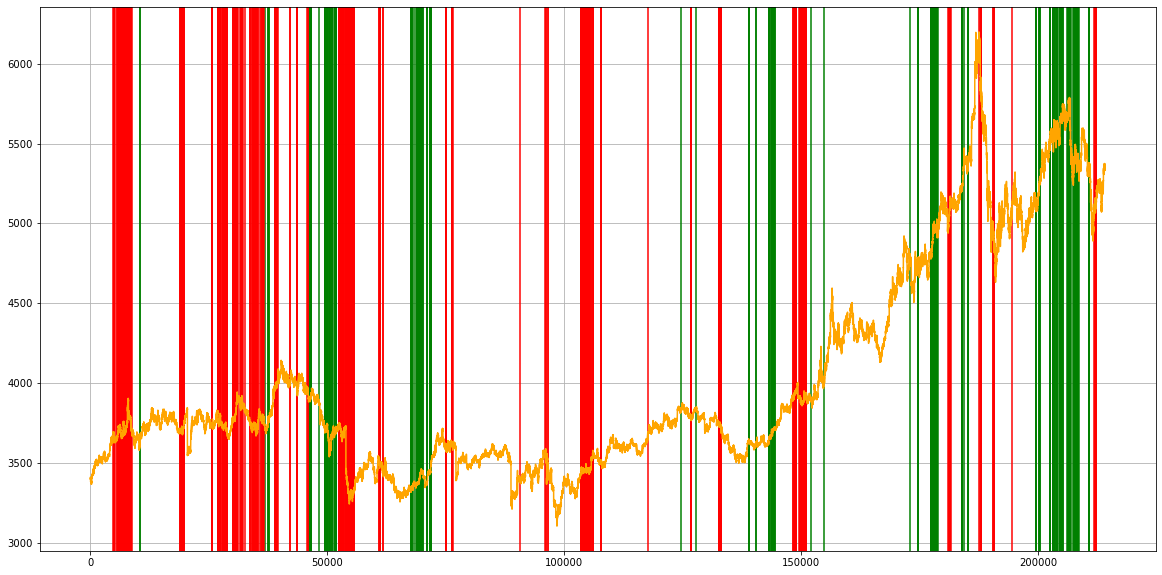

In [24]:
figure(figsize = (20, 10))
for el in a:
    axvline(el, c = 'g')
for el in b:
    axvline(el, c = 'r')
plot(main['close'], c = 'orange')
grid()
show()

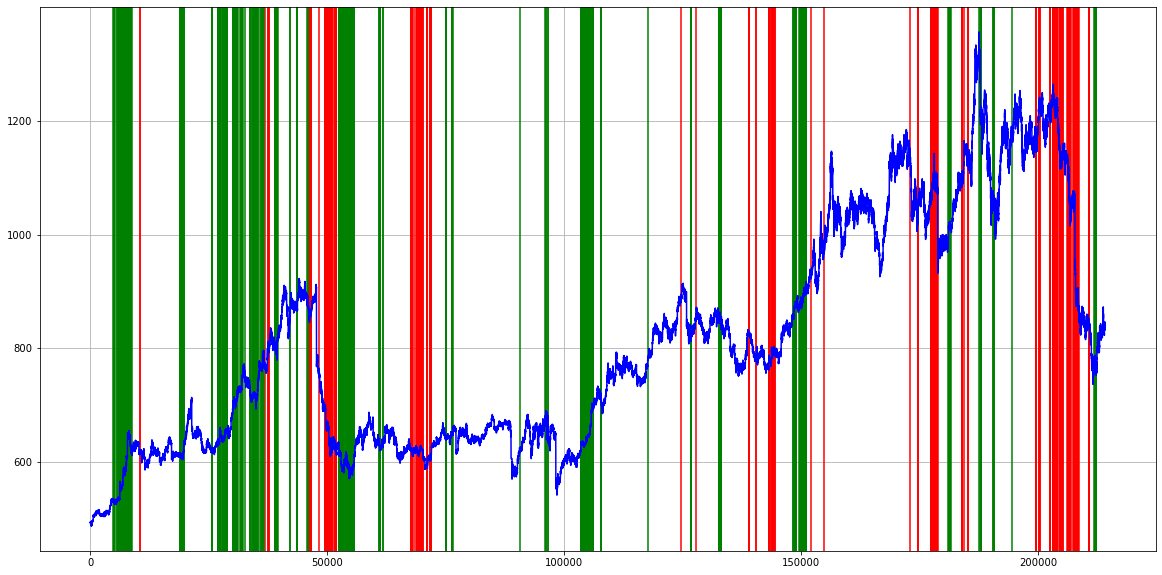

In [23]:
figure(figsize = (20, 10))
for el in a:
    axvline(el, c = 'r')
for el in b:
    axvline(el, c = 'g')
plot(hedge['close'], c ='b')
grid()
show()

In [16]:
Base_Strategy.calc_bias(main, hedge)[0].min(), Base_Strategy.calc_bias(main, hedge)[0].max()

(-62.588567690172724, 54.1062135660722)

In [17]:
Base_Strategy.calc_bias(main, hedge)[1].min(), Base_Strategy.calc_bias(main, hedge)[1].max()

(-45.240739240511715, 31.36402903836072)

In [18]:
Base_Strategy.calc_bias(main, hedge)[1]

0              NaN
60             NaN
120            NaN
180            NaN
240            NaN
            ...   
213780    2.758974
213840    4.472740
213900    5.622671
213960    5.268854
214020    3.400778
Name: close, Length: 3568, dtype: float64

In [19]:
Base_Strategy.RSI(main)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
214075    50.155165
214076    47.741953
214077    47.153746
214078    47.153746
214079    47.153746
Name: close, Length: 214080, dtype: float64

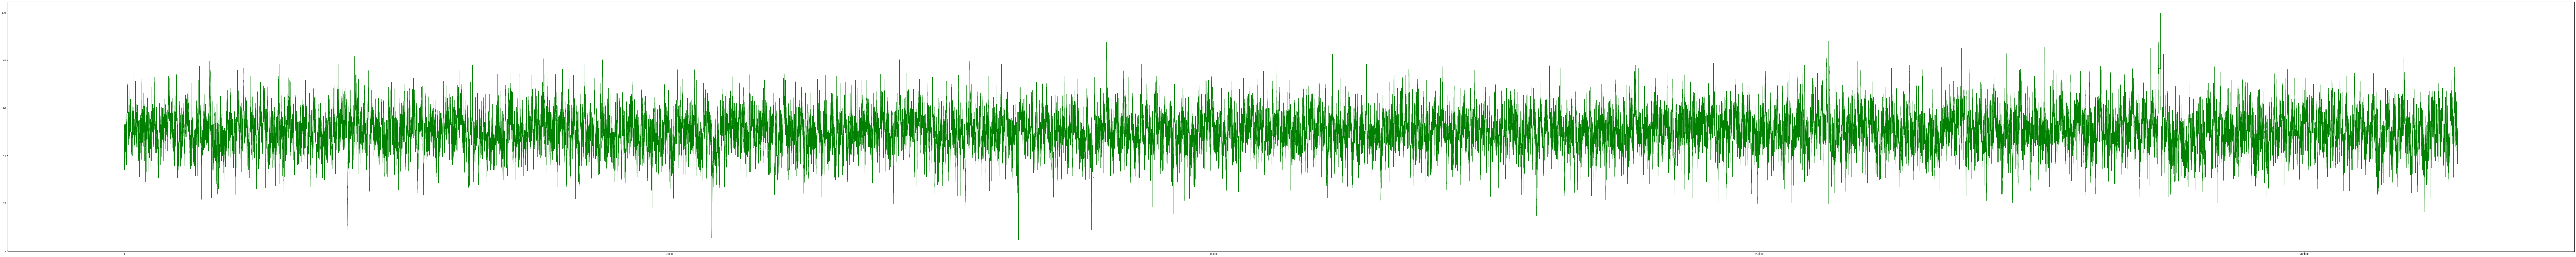

In [20]:
figsize(200, 20)
plot(Base_Strategy.RSI(main), color = 'g')

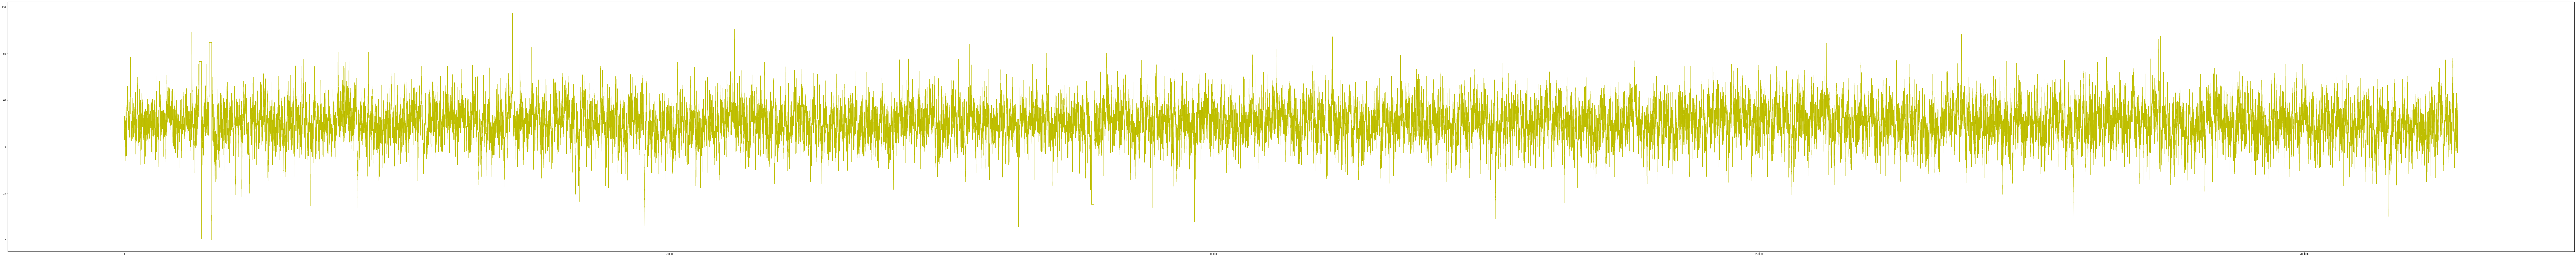

In [21]:
figsize(200, 20)
plot(Base_Strategy.RSI(hedge), color = 'y')

In [22]:
Base_Strategy.RSI(hedge).min(), Base_Strategy.RSI(hedge).max()

(0.0077114743899642235, 97.44955685835751)